## Project 5 - Vehicle Detection

### Histogram of Gradients (HOG) and other extracted features
`Source: train.py & feature_extration.py`

Code for extracting HOG and other features is in `feature_extraction.py`. After much trial and error training the classifier, I found some variables that gave me the best results.

The image is converted to the `YCrCb` colorspace. I tried several color spaces including `RGB`, `HSV` & `HSL`, but settled on `YCrCb`

I generate the HOG for each color channel with 9 orientations, 8 pixels per cell, and 2 cells per block. For a 64x64 image, this returns 1764 features per channel or an array of shape (7, 7, 2, 2, 9) before flattening. That's a total of 5292 features.

I take the color histogram of each color channel and concatenate them together. I divide the histogram into 32 bins. Adding the three bins, this returns a total of 96 features.

Finally, I do a spatial binning after resizing the image to 32x32. Which really just flattens the image array. So for a 32x32 image with 3 channels, we get 3072 features.

There is a total of 8460 features per image.

### Training the Classifier
`Source: train.py`

The model is trained using a `LinearSVC` classifier. I also tried a `DecisionTreeClassifier` but got better results in faster time using the `LinearSVC`. The classifier had an accuracy score of 0.995.

`StandardScaler` was used once all the features were extracted to scale the features down evenly with a zero mean.

This training step is meant to be done ahead of time. The fitted classifier and scaler are saved to `model_data.pkl` so it can later be loaded without needing to retrain every time a prediction is needed.

### Sliding Window Search
`Source sliding_window.py`

The sliding window approach is very similar to what was covered in the course, but I did make some small changes. The `sliding_window_list` method accepts a start (top-left x, y) and end (bottom-right x, y). You can also pass in the number of pixels per step and a scale. The scale determines how large of a window size you'd like for each sliding window. A scale of one, means the sliding window matches the size of the feature input which is 64x64. A scale of two means each sliding window will be 128x128. This scale is also returned with each sliding window output in order to compute HOG features later on.

In order to reduce the number of false positives, the sliding windows are only chosen on the bottom half of the image. Until flying cars exist, there's no reason to search the sky for cars. :) The sliding window is only searching the right half of the image. This was done more to speed up the processing, but also makes sense since vehicles on the left side of the screen are blocked by the highway median.

### Detection
`Source: detect.py`

Vehicle detection is done by iterating through each sliding window, calculating the feautes for each sliding window then running that through the classifier. If a car is predicted, the sliding window boundaries are saved. Each sliding window that was predicted to have a car combined and a heatmap of all those rectangles is created. Only rectangles that overlap at least once are considered actual cars. This is to reduce the number of false positives.

One detection optimization I made was to calculate the image HOG for the entire area of interest up front, rather than calculating the HOG for each sliding window. This gave me about a 3x speed improvement.

Below are the detected vehicles in the test images.

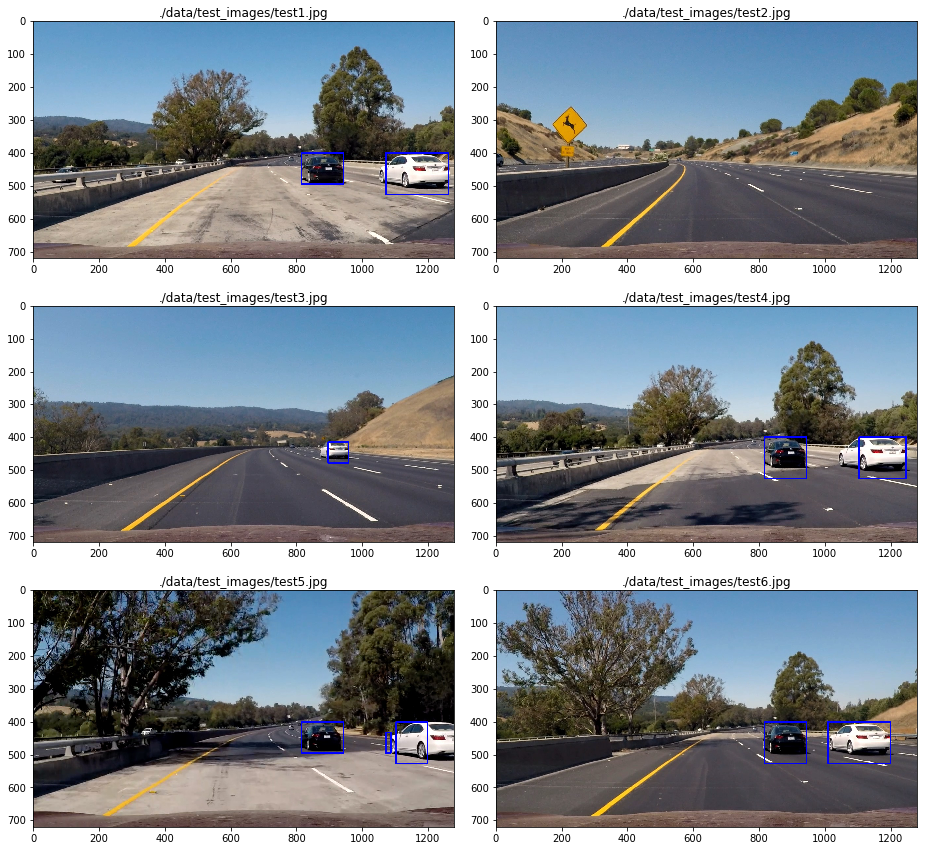

In [8]:
%matplotlib inline

from detect import Detection, create_windows
from model import Model
from image import rgb_image
import glob
import matplotlib.pyplot as plt

def plot_detected_vehicle_image(ax, model, windows, filename):
    detection = Detection(model, windows)
    image = rgb_image(filename)
    image = detection.detect(image)
    ax.set_title(filename)
    ax.imshow(image)
    
model = Model()
windows = create_windows()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(13, 12))
f.tight_layout()

plot_detected_vehicle_image(ax1, model, windows, "./data/test_images/test1.jpg")
plot_detected_vehicle_image(ax2, model, windows, "./data/test_images/test2.jpg")
plot_detected_vehicle_image(ax3, model, windows, "./data/test_images/test3.jpg")
plot_detected_vehicle_image(ax4, model, windows, "./data/test_images/test4.jpg")
plot_detected_vehicle_image(ax5, model, windows, "./data/test_images/test5.jpg")
plot_detected_vehicle_image(ax6, model, windows, "./data/test_images/test6.jpg")

plt.show()

### Video
`convert_video.py`

This vehicle detection method is run for each image in the `project_video.mp4` file. Since we have more frames of reference, the heatmap for the past 3 frames are stored and the bounding boxes for the cars are detected from this history of heatmaps. This is to reduce the amount of jittering and jumping around of the detected vehicle boxes. This works well, you can see the output video at `output/project_video.mp4` or on YouTube by [clicking here](https://www.youtube.com/watch?v=3IInKYb55cs).

### Discussion

More work can be done on smoothing out the detection boxes. The is still some visible jittering between frames. Detection fails if cars are on the left half of the screen. This was a choice I made in order to speed up the processing, but a quick way to fix it would be to expand the area the sliding windows search through.